### Notebook to run WeightWatcher on Task1 and Task2 contest public_data

In [1]:
import json
import numpy as np
import pandas as pd



import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext watermark
%watermark

2020-10-02T18:08:16-07:00

CPython 3.8.5
IPython 7.17.0

compiler   : Clang 10.0.0 
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Ensure that public_data and starting_kit are in the local folder

In [60]:
ls

README.md                book/                    ww_results/
WWContestAnalysis.ipynb  public_data@
WWContestRuns.ipynb      starting_kit@


In [3]:
this_task = "task2_v1"

In [5]:
ls public_data/input_data/$this_task

LICENSE     model_1008/ model_245/  model_255/  model_620/  model_994/
dataset_1/  model_1009/ model_246/  model_256/  model_621/  model_995/
model_1000/ model_1010/ model_247/  model_612/  model_622/  model_996/
model_1001/ model_1011/ model_248/  model_613/  model_623/  model_997/
model_1002/ model_239/  model_249/  model_614/  model_624/  model_998/
model_1003/ model_240/  model_250/  model_615/  model_625/  model_999/
model_1004/ model_241/  model_251/  model_616/  model_626/
model_1005/ model_242/  model_252/  model_617/  model_627/
model_1006/ model_243/  model_253/  model_618/  model_628/
model_1007/ model_244/  model_254/  model_619/  model_629/


#### Read all model datafile

In [6]:
import glob, re

path = r"./ww_results/{}/model_*".format(this_task)
regex = re.compile(path, re.IGNORECASE)

all_details = {}
for fullname in glob.glob(path): 
    mid = re.sub(path,'', fullname).replace('.csv', '')
    all_details[mid] = pd.read_csv(fullname)

num = len(all_details)
print("Read {} details dataframes for {}".format(num, this_task))
assert(num>0)

Read 54 details dataframes for task2_v1


#### Read Test Accuracies from Reference Data

### 

<ipython-input-7-69f70b9bd5d5>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


task1_v4
task2_v1


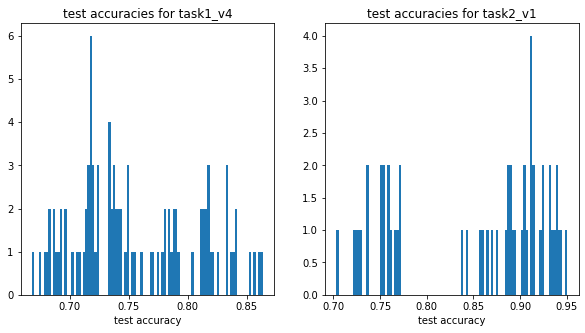

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

fig, axes = plt.subplots(1,2)
subplts = axes.flatten()[::-1].tolist()

test_accuracies = {}
for task in ["task1_v4", "task2_v1"]:
    subplt = subplts.pop()
    
    filename = "./public_data/reference_data/{}/model_configs.json".format(task)
    with open(filename) as f:
        data = json.load(f)

    test_accuracies[task]= {}
    for k, v in data.items():
        test_accuracies[task][int(k)]=v['metrics']['test_acc']

    subplt.hist(test_accuracies[task].values(), bins=100);
    subplt.set_title("test accuracies for {}".format(task))
    subplt.set_xlabel("test accuracy")
fig.show()
    
    
dev_names = {}
for task in ["task1_v4", "task2_v1"]:
    print(task)
    filename = "./public_data/reference_data/{}/model_configs.json".format(task)
    with open(filename) as f:
        data = json.load(f)

    dev_names[task]={}
    for k, v in data.items():
        dev_names[task][int(k)]=v['dev_name']

### Basic Plots

In [8]:

from pylab import rcParams
rcParams['figure.figsize'] = 10,10

def compare_details(m1, m2):
    d1 = all_details["model_{}".format(m1)]
    d2 = all_details["model_{}".format(m2)]
    
    d1 = d1[d1['comment']=='Layer level']
    d2 = d2[d2['comment']=='Layer level']

    a1 = d1[metric].dropna().values
    a2 = d2[metric].dropna().values
    
    print(dev_names[this_task][(m1)])
    display(d1)
    
    print(dev_names[this_task][(m2)])
    display(d2)
    
    
def compare_metrics(m1, m2, metric='alpha'):

    title = "{} compare: test accuracies \n models {}={:0.4}   {}={:0.4}".format(
        this_task, m1, 100*test_accuracies[this_task][m1], m2, 100*test_accuracies[this_task][m2])
        
    title = "{} vs {}".format(m1,m2)

    d1 = all_details["model_{}".format(m1)]
    d2 = all_details["model_{}".format(m2)]
    
    d1 = d1[d1['comment']=='Layer level']
    d2 = d2[d2['comment']=='Layer level']

    a1 = d1[metric].dropna().values
    a2 = d2[metric].dropna().values

    
    x = np.array(d1.index)
    plt.scatter(x,a1, label="{}".format(m1))
    x = np.array(d2.index)
    plt.scatter(x,a2, label="{}".format(m2))
    plt.legend()
    plt.ylabel(metric)
    plt.title(title)
    plt.show()
    


In [9]:
def model_num(k):
    return int(int(k)/100)

#          0.     1.  2.  -    4.    5        6       7          8       9      10
colors = ['teal','g','b','b', 'b', 'purple', 'c', 'darkgreen', 'red', 'orange', 'm']

def mid_color(mid):
    return colors[model_num(mid)]

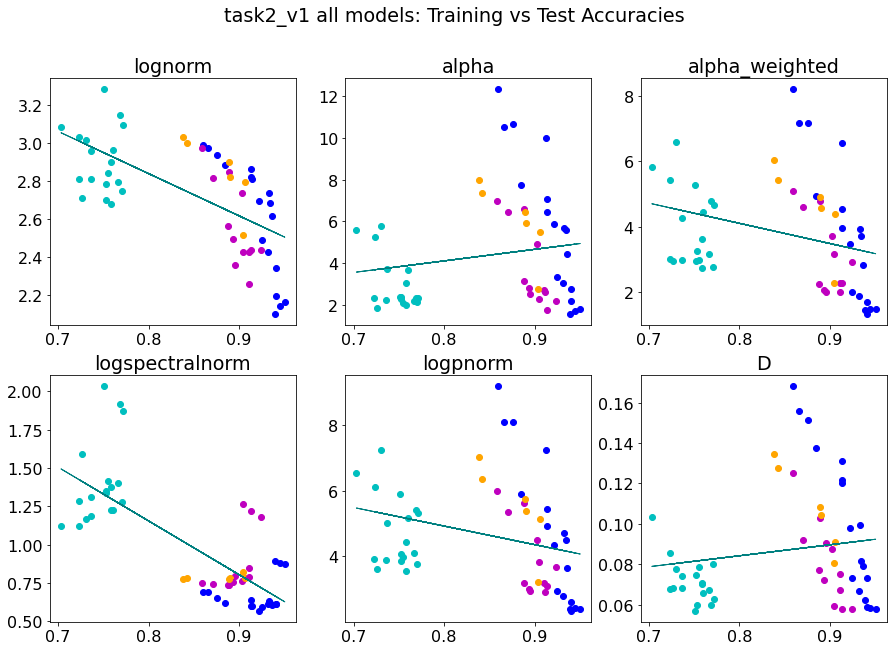

In [10]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats

from scipy.stats import kendalltau, spearmanr

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
rcParams.update({'font.size': 16})

fig, axes = plt.subplots(2,3)
subplts = axes.flatten()[::-1].tolist()
fig.suptitle("{} all models: Training vs Test Accuracies".format(this_task))


errors = {}
for metric in ['lognorm', 'alpha', 'alpha_weighted', 'logspectralnorm', 'logpnorm', 'D']:#'softrank', 'D']:
    errors[metric] = {}
    x, y = [], []
    subplt = subplts.pop()
    
    for mid, details in all_details.items():
        # remove first and last layers / min_size = 20 really
        details = details[details['N']> 10]
        details = details[details['M']> 10]

        yval = details[metric].dropna().mean()
        test_accuracy = test_accuracies[this_task][int(mid)]

        #if  yval < 8:
        #if test_accuracy > 0.80:
        #if int(mid) > 200 and int(mid) < 300 :
        x.append(test_accuracy)
        y.append(yval)
        #subplt.annotate("{}".format(mid), (test_accuracy,yval))
        subplt.scatter(test_accuracy, yval, color=mid_color(mid))

    
    x = np.array(x).reshape(-1,1)
    y = np.array(y).reshape(-1,1)
    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    subplt.plot(x, y_pred, color='teal', linewidth=1)
    
    R2 = r2_score(y, y_pred)
    MSE = mean_squared_error(y, y_pred)
    MAE = mean_absolute_error(y, y_pred)
    
    errors[metric]['MSE'] = MSE
    errors[metric]['MAE'] = MAE
    errors[metric]['R2'] = R2

    tau, p_value = stats.kendalltau(x, -y)
    errors[metric]['kendal_tau']= tau
    errors[metric]['kendal_p_value']= p_value
    
    spman, p_value = spearmanr(x, -y)
    errors[metric]['spearman_tau']= spman
    errors[metric]['spearman_p_value']= p_value

    #subplt.set_xlabel('test accuracy')
    #subplt.set_ylabel(metric)
    subplt.set_title(metric)
#                     "+r"$R^{2} {:0.3} $\tau$ {:0.3}  SP {:0.3}"
    


In [15]:
mids

{200, 600, 900, 1000}

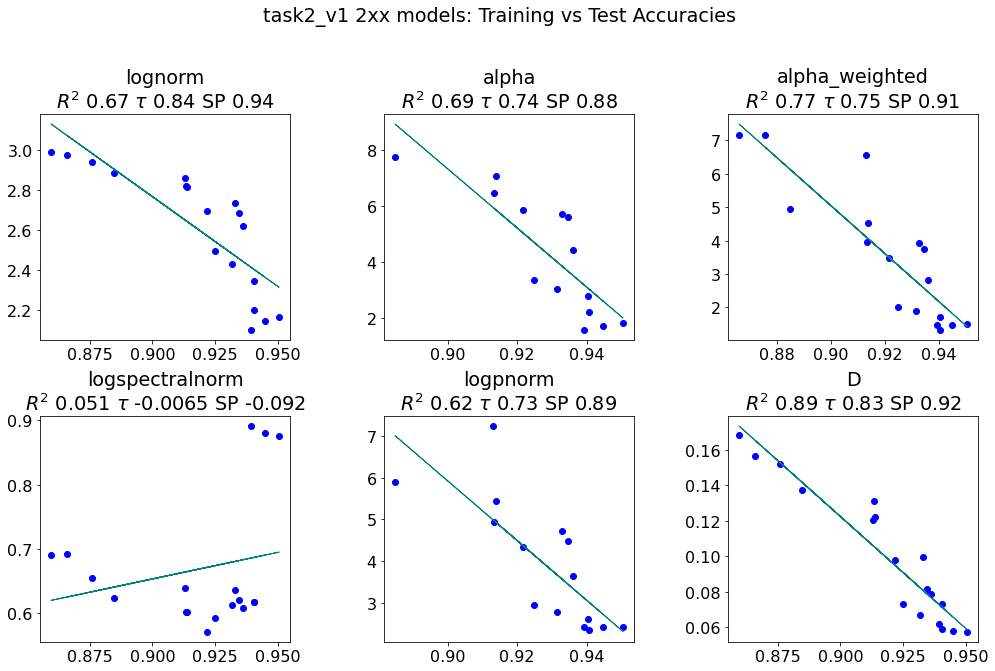

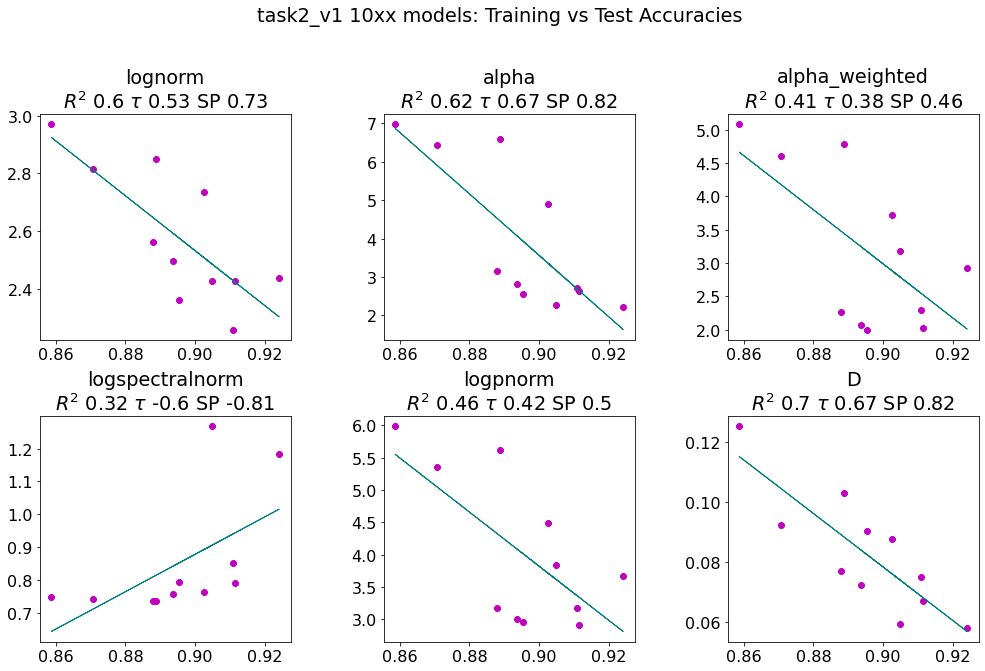

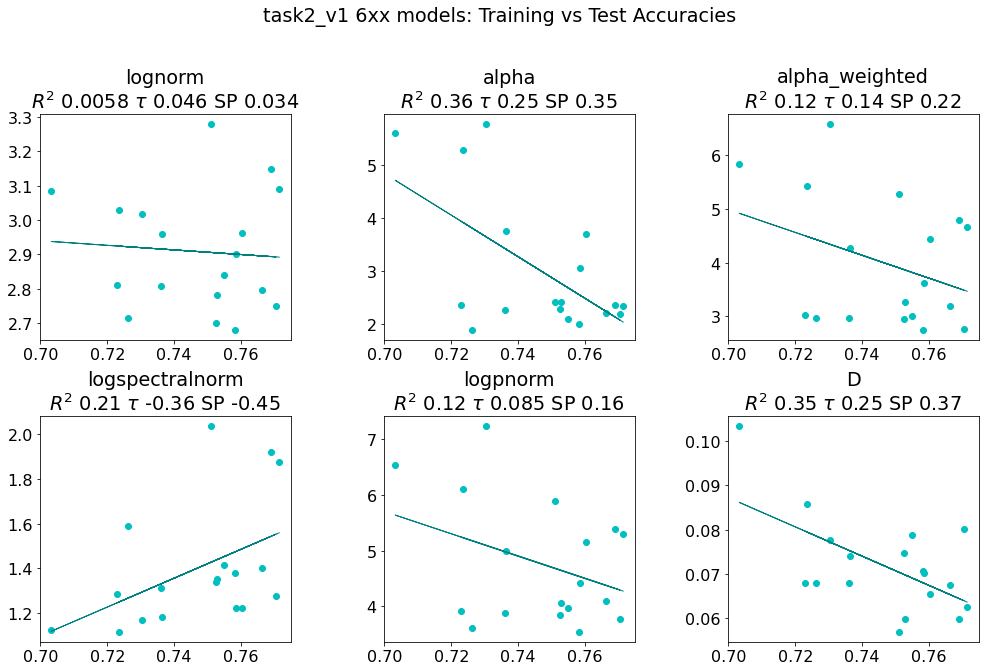

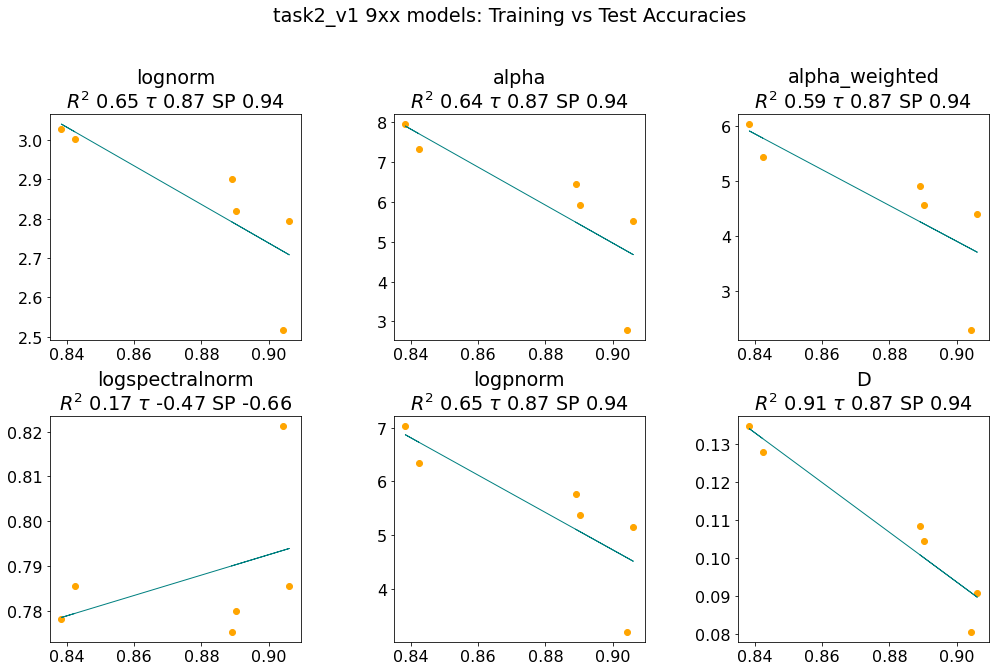

In [16]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import scipy.stats as stats

from scipy.stats import kendalltau, spearmanr

from pylab import rcParams
rcParams['figure.figsize'] = 15,10
rcParams.update({'font.size': 16})

errors = {}

mids = set([100*model_num(k) for k in all_details.keys()])

for mid in mids:
       
    fig, axes = plt.subplots(2,3)
    subplts = axes.flatten()[::-1].tolist()
    fig.suptitle("{} {}xx models: Training vs Test Accuracies".format(this_task, model_num(mid)))
    fig.tight_layout(pad=3.0)


    errors[mid] = {}
    for metric in ['lognorm', 'alpha', 'alpha_weighted', 'logspectralnorm', 'logpnorm', 'D']:#'softrank', 'D']:
        errors[mid][metric] = {}
        x, y = [], []
        subplt = subplts.pop()

        for model, details in all_details.items():
            # remove first and last layers / min_size = 20 really
            details = details[details['N']> 10]
            details = details[details['M']> 10]

            yval = details[metric].dropna().mean()

            if yval < 8:
                this_mid = model.replace("model_", '')
                test_accuracy = test_accuracies[this_task][int(this_mid)]

                if int(this_mid) > mid and int(this_mid) < mid+100 :
                    x.append(test_accuracy)
                    y.append(yval)
                    subplt.scatter(test_accuracy, yval, color=mid_color(mid))
                    

        if len(x)>0:
            x = np.array(x).reshape(-1,1)
            y = np.array(y).reshape(-1,1)
            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            y_pred = regr.predict(x)
            subplt.plot(x, y_pred, color='teal', linewidth=1)
                
            R2 = r2_score(y, y_pred)
            MSE = mean_squared_error(y, y_pred)
            MAE = mean_absolute_error(y, y_pred)

            errors[mid][metric]['MSE'] = MSE
            errors[mid][metric]['MAE'] = MAE
            errors[mid][metric]['R2'] = R2

            tau, p_value = stats.kendalltau(x, -y)
            errors[mid][metric]['kendal_tau']= tau
            errors[mid][metric]['kendal_p_value']= p_value


            spman, p_value = spearmanr(x, -y)
            errors[mid][metric]['spearman_tau']= spman
            errors[mid][metric]['spearman_p_value']= p_value
            
            title = metric +"\n"+r"$R^2$ {:0.2} $\tau$ {:0.2} SP {:0.2}".format(R2, tau, spman)
            subplt.set_title(title)
        
  

In [18]:
for metric in ['lognorm', 'alpha', 'alpha_weighted', 'logspectralnorm', 'logpnorm', 'D']:#, 'softrank']:
    
    print("{}: Rank correlation metrics for Task 1 #xx models".format(metric))
    print("#xx   Kendal   Spearmanr")


    for mid in 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000:
        try:

            df = pd.DataFrame(errors[mid])
            k_tau = df.loc['kendal_tau'][metric]
            sp_tau = df.loc['spearman_tau'][metric]
            print("{}xx   {:0.3}   {:0.3}".format(int(mid/100), k_tau, sp_tau))
        except:
            pass

    print("\n\n")

lognorm: Rank correlation metrics for Task 1 #xx models
#xx   Kendal   Spearmanr
2xx   0.843   0.94
6xx   0.0458   0.0341
9xx   0.867   0.943
10xx   0.527   0.727



alpha: Rank correlation metrics for Task 1 #xx models
#xx   Kendal   Spearmanr
2xx   0.736   0.881
6xx   0.255   0.348
9xx   0.867   0.943
10xx   0.673   0.818



alpha_weighted: Rank correlation metrics for Task 1 #xx models
#xx   Kendal   Spearmanr
2xx   0.75   0.909
6xx   0.137   0.222
9xx   0.867   0.943
10xx   0.382   0.464



logspectralnorm: Rank correlation metrics for Task 1 #xx models
#xx   Kendal   Spearmanr
2xx   -0.00654   -0.0918
6xx   -0.359   -0.451
9xx   -0.467   -0.657
10xx   -0.6   -0.809



logpnorm: Rank correlation metrics for Task 1 #xx models
#xx   Kendal   Spearmanr
2xx   0.733   0.889
6xx   0.085   0.156
9xx   0.867   0.943
10xx   0.418   0.5



D: Rank correlation metrics for Task 1 #xx models
#xx   Kendal   Spearmanr
2xx   0.83   0.924
6xx   0.255   0.366
9xx   0.867   0.943
10xx   0.673   0.818